# Cell 0 — BigQuery Client Setup

Initializes the BigQuery client using default Vertex AI credentials for querying data.










In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account

# Assumes credentials are handled by the Vertex AI environment
bq_client = bigquery.Client(project="xi-labs")

# Cell A — Investigation Configuration Setup

Defines key parameters for the investigation:

Investigation label

Target email addresses

Time window (start and end dates based on lookback period)
Stores all values in a central INVESTIGATION_CONFIG dictionary for downstream use.

In [4]:
from datetime import datetime, timedelta

# User-defined input
investigation_label = input("Enter investigation label: ").strip()

raw_emails = input("Enter comma-separated target emails: ").strip()
TARGET_EMAILS = [e.strip() for e in raw_emails.split(",") if e.strip()]

LOOKBACK_WEEKS = int(input("Lookback period (in weeks): ").strip())

# Date calculations
TODAY = datetime.utcnow()
LOOKBACK_START = TODAY - timedelta(weeks=LOOKBACK_WEEKS)

# Store config
INVESTIGATION_CONFIG = {
    "investigation_label": investigation_label,
    "target_emails": TARGET_EMAILS,
    "lookback_start": LOOKBACK_START.strftime("%Y-%m-%d"),
    "lookback_end": TODAY.strftime("%Y-%m-%d"),
}
INVESTIGATION_CONFIG


Enter investigation label: IL-IR NGV
Enter comma-separated target emails: simon.browntechnologies@gmail.com,   blakejimmy111@gmail.com,   julla24@icloud.com
Lookback period (in weeks): 3


{'investigation_label': 'IL-IR NGV',
 'target_emails': ['simon.browntechnologies@gmail.com',
  'blakejimmy111@gmail.com',
  'julla24@icloud.com'],
 'lookback_start': '2025-07-02',
 'lookback_end': '2025-07-23'}

# Cell B — Get Most Recent TTS Activity per Email
Purpose:
Fetches the latest TTS activity timestamp for each target email from the past TTS usage logs.

Inputs used:

INVESTIGATION_CONFIG["target_emails"] (from Cell A)

Output:
A DataFrame (recent_tts_df) with:
* user_email
* last_tts_activity (latest generation timestamp for that user)

Why it matters:
This shows you whether these accounts have been recently active — a useful sanity check and indicator of recent abuse window. Helps validate if further digging is worth it.

In [5]:
QUERY = f"""
SELECT
  user_email,
  MAX(timestamp) AS last_tts_activity
FROM
  `xi-labs.xi_prod.tts_usage_partitioned`
WHERE
  user_email IN UNNEST(@target_emails)
GROUP BY
  user_email
ORDER BY
  last_tts_activity DESC
"""

job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("target_emails", "STRING", INVESTIGATION_CONFIG["target_emails"]),
    ]
)

query_job = bq_client.query(QUERY, job_config=job_config)
recent_tts_df = query_job.to_dataframe()

print("🔍 Most Recent TTS Activity per Email:")
recent_tts_df

🔍 Most Recent TTS Activity per Email:


,user_email,last_tts_activity
0,blakejimmy111@gmail.com,2025-07-15 11:06:41.577471+00:00
1,simon.browntechnologies@gmail.com,2025-07-01 12:20:30.107547+00:00
2,julla24@icloud.com,2025-06-18 14:00:21.216524+00:00


# Cell C — Cleaned Usage & Abuse Risk Profile

What this cell does:
* Fetches usage and abuse metadata for each of your TARGET_EMAILS from the
 dim_users table, to give you:

    * Account IDs (user_id)
    * Last action dates on ConvAI + STT
    * Character usage stats
    * TTS activity metrics
    * NGV (No-Go Voice) attempts
    * Violation category percentages (scam, hate, sexual, political, etc.)



In [6]:
DIM_USERS_QUERY = """
SELECT
  email,
  userid AS user_id,
  last_convai_action_date,
  last_stt_action_date,
  convai_characters_last_30_days,
  stt_characters_last_30_days,
  total_tts_generations_l30,
  ngv_ivcs,
  pct_violation_generations_l30,
  pct_political_generations_l30,
  pct_scam_generations_l30,
  pct_hate_generations_l30,
  pct_harm_generations_l30,
  pct_sexual_minors_generations_l30,
  pct_non_us_political_generations_l30
FROM
  `xi-analytics.dbt_marts.dim_users`
WHERE
  email IN UNNEST(@target_emails)
ORDER BY
  last_stt_action_date DESC NULLS LAST, last_convai_action_date DESC NULLS LAST
"""

dim_users_job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("target_emails", "STRING", INVESTIGATION_CONFIG["target_emails"]),
    ]
)

dim_users_job = bq_client.query(DIM_USERS_QUERY, job_config=dim_users_job_config)
dim_users_df = dim_users_job.result().to_dataframe()

# 🧹 Drop any column that is fully NaN
dim_users_df_cleaned = dim_users_df.dropna(axis=1, how='all')

print("📊 30d Usage & Risk Profile (cleaned):")
dim_users_df_cleaned

📊 30d Usage & Risk Profile (cleaned):


,email,user_id,convai_characters_last_30_days,stt_characters_last_30_days,total_tts_generations_l30,ngv_ivcs,pct_violation_generations_l30,pct_political_generations_l30,pct_scam_generations_l30,pct_hate_generations_l30,pct_harm_generations_l30,pct_sexual_minors_generations_l30,pct_non_us_political_generations_l30
0,julla24@icloud.com,pBpwtL8Rh6NtdwFJHW4i2TcgOAy1,0,0,<NA>,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,simon.browntechnologies@gmail.com,vqpTiIbNZyRetoDZt4QYpTNR3Bf1,0,0,196,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,blakejimmy111@gmail.com,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,0,0,8207,0,0.0,0.002559,0.0,0.0,0.0,0.0,0.0


# Cell D1 — Pull Raw TTS Generations with IPs

Purpose:
 * Pulls raw TTS generations for your target_emails
 * Only includes rows within the lookback window (defined in Cell A)
 * Captures metadata: user, timestamp, voice, workspace, user_uid, and IP address

Inputs Used:
INVESTIGATION_CONFIG["target_emails"]
INVESTIGATION_CONFIG["lookback_start"]
INVESTIGATION_CONFIG["lookback_end"]

Output:
DataFrame tts_df with these columns:
user_email, timestamp, voice_name, voice_category, workspace_id, user_uid, text, ip

In [7]:
# @title Cell D1 — Pull Raw TTS Generations with IPs

TTS_ALL_QUERY = """
SELECT
  user_email,
  timestamp,
  voice_name,
  voice_category,
  workspace_id,
  user_uid,
  text,
  ip  -- ✅ include IP address
FROM
  `xi-labs.xi_prod.tts_usage_partitioned`
WHERE
  user_email IN UNNEST(@target_emails)
  AND DATE(timestamp) BETWEEN @start_date AND @end_date
ORDER BY
  user_email, voice_name, timestamp
"""

tts_all_job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("target_emails", "STRING", INVESTIGATION_CONFIG["target_emails"]),
        bigquery.ScalarQueryParameter("start_date", "DATE", INVESTIGATION_CONFIG["lookback_start"]),
        bigquery.ScalarQueryParameter("end_date", "DATE", INVESTIGATION_CONFIG["lookback_end"]),
    ]
)

tts_all_job = bq_client.query(TTS_ALL_QUERY, job_config=tts_all_job_config)
tts_df = tts_all_job.result().to_dataframe()

print("📥 Pulled TTS generations with IPs included:")
tts_df


📥 Pulled TTS generations with IPs included:


,user_email,timestamp,voice_name,voice_category,workspace_id,user_uid,text,ip
0,blakejimmy111@gmail.com,2025-07-06 07:38:48.753072+00:00,Angry Speaker,professional,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,خامنه‌ای، رهبر عالی مقام ایران در سی و شش سال ...,62.90.107.165
1,blakejimmy111@gmail.com,2025-07-06 07:38:49.545027+00:00,Angry Speaker,professional,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,[frustrated] او کشور را بدون برق، بدون آب و بد...,62.90.107.165
2,blakejimmy111@gmail.com,2025-07-06 07:38:49.855437+00:00,Angry Speaker,professional,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,[resolute] مردم دیگر تحمل ندارند!,62.90.107.165
3,blakejimmy111@gmail.com,2025-07-06 07:38:50.020187+00:00,Angry Speaker,professional,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,[commanding] ای خامنه ای، از ایران بیرون شو، گ...,62.90.107.165
4,blakejimmy111@gmail.com,2025-07-06 07:39:14.218490+00:00,Angry Speaker,professional,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,خامنه‌ای، رهبر عالی مقام ایران در سی و شش سال ...,62.90.107.165
...,...,...,...,...,...,...,...,...
443,blakejimmy111@gmail.com,2025-07-08 09:25:26.562539+00:00,persian male 3,generated,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,#خط_قرمز_تو_چیه؟,45.144.113.11
444,blakejimmy111@gmail.com,2025-07-08 09:25:39.019793+00:00,persian male 3,generated,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,او فقط دستور را اجرا کرد\nاو فقط دستور را اجرا...,45.144.113.11
445,blakejimmy111@gmail.com,2025-07-08 09:25:39.267651+00:00,persian male 3,generated,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,برادر بسیجی، کی تصمیم می‌گیری که دستور از خط ق...,45.144.113.11
446,blakejimmy111@gmail.com,2025-07-08 09:25:39.584102+00:00,persian male 3,generated,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,ما قسم خوردیم که از مردم دفاع کنیم، نه اینکه ا...,45.144.113.11


# Cell D2 — Stitch TTS Generations into Narrative Blocks by Session

Purpose:
Groups consecutive generations from the same user_email and voice_name into session-based blocks.

A new block starts when:
The session_id changes (group boundary)

For each block, it:
 * Aggregates text into a single full_text
 * Tracks start and end timestamps
 * Counts number of generations
 * Tracks all unique IPs used

Inputs Used:
* tts_df from Cell D1
* Assumes session_id column is already present in tts_df (⚠️ if not, we can adjust logic to group by timestamp gaps instead)

Output:
* DataFrame stitched_df with:
    * user_email, voice_name, voice_category, workspace_id, user_uid start_time, end_time, tts_count
* full_text: merged text from all generations
* ips: newline-separated string of all IPs used in that session



In [9]:
# @title Cell D2 — Stitch TTS Generations into Narrative Blocks by Session
import pandas as pd
stitched_rows = []
prev_row = None

for idx, row in tts_df.iterrows():
    ip = row.get("ip", None)

    if (
        prev_row is not None
        and row["user_email"] == prev_row["user_email"]
        and row["voice_name"] == prev_row["voice_name"]
        and row.get("session_id") == prev_row.get("session_id")  # session-based stitching
    ):
        # Continue existing stitched block
        stitched_rows[-1]["end_time"] = row["timestamp"]
        stitched_rows[-1]["tts_count"] += 1
        stitched_rows[-1]["full_text"] += " " + str(row["text"]).strip()
        if ip:
            stitched_rows[-1]["ips"].add(ip)
    else:
        # Start new stitched block
        stitched_rows.append({
            "user_email": row["user_email"],
            "voice_name": row["voice_name"],
            "voice_category": row["voice_category"],
            "workspace_id": row["workspace_id"],
            "user_uid": row["user_uid"],
            "start_time": row["timestamp"],
            "end_time": row["timestamp"],
            "tts_count": 1,
            "full_text": str(row["text"]).strip(),
            "ips": set([ip]) if ip else set(),
        })
    prev_row = row

# Convert IP sets to newline-separated strings
for row in stitched_rows:
    row["ips"] = "\n".join(sorted(row["ips"]))

stitched_df = pd.DataFrame(stitched_rows)

print("🧵 Stitched Narratives (by session):")
stitched_df


🧵 Stitched Narratives (by session):


,user_email,voice_name,voice_category,workspace_id,user_uid,start_time,end_time,tts_count,full_text,ips
0,blakejimmy111@gmail.com,Angry Speaker,professional,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-06 07:38:48.753072+00:00,2025-07-06 10:37:00.625397+00:00,58,خامنه‌ای، رهبر عالی مقام ایران در سی و شش سال ...,185.195.59.183\n62.90.107.165
1,blakejimmy111@gmail.com,Bill,premade,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 09:19:30.856010+00:00,2025-07-08 09:19:32.546575+00:00,8,[resigned] او فقط دستور را اجرا کرد.\n[flatly]...,45.144.113.11
2,blakejimmy111@gmail.com,Brian,premade,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 09:20:16.010330+00:00,2025-07-08 09:20:18.937973+00:00,8,[resigned] او فقط دستور را اجرا کرد.\n[flatly]...,45.144.113.11
3,blakejimmy111@gmail.com,Callum,premade,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-06 07:37:35.043944+00:00,2025-07-06 07:37:37.283223+00:00,8,خامنه‌ای، رهبر عالی مقام ایران در سی و شش سال ...,62.90.107.165
4,blakejimmy111@gmail.com,Chris,professional,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 09:12:41.233419+00:00,2025-07-08 11:24:50.455726+00:00,62,[earnest] برادران بسیجی، به شما گفتن که من دشم...,185.190.141.177\n45.144.113.11\n45.144.113.8
5,blakejimmy111@gmail.com,Daniel,premade,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 09:21:29.037614+00:00,2025-07-08 09:24:46.371600+00:00,8,[resigned] او فقط دستور را اجرا کرد.\n[flatly]...,45.144.113.11
6,blakejimmy111@gmail.com,Drew,premade,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 09:22:12.224145+00:00,2025-07-08 09:24:04.900063+00:00,24,[resigned] او فقط دستور را اجرا کرد.\n[flatly]...,45.144.113.11
7,blakejimmy111@gmail.com,Josh,premade,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 09:24:23.146674+00:00,2025-07-08 09:24:58.117680+00:00,14,[resigned] او فقط دستور را اجرا کرد.\n[flatly]...,45.144.113.11
8,blakejimmy111@gmail.com,Lucan Rook - Energetic Male,professional,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-06 07:36:42.723140+00:00,2025-07-06 07:36:43.925882+00:00,4,خامنه‌ای، رهبر عالی مقام ایران در سی و شش سال ...,62.90.107.165
9,blakejimmy111@gmail.com,Monster Of Rock - Deep N Tough,professional,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-15 11:06:18.230635+00:00,2025-07-15 11:06:41.577471+00:00,2,ز یه طرف، ایران پولداره!\nکشوریه که سومین صادر...,154.16.157.46


# Cell E1 — Extract Unique User IDs from Stitched Narratives

Isolate user_uids from the stitched narratives so you can trace all associated device fingerprints and IPs in later steps.

Purpose:
Pulls distinct user_uid values from the stitched narrative data (stitched_df).

These user_uids represent the confirmed users from your original target emails who had TTS activity.

Inputs Used:
* stitched_df — generated in Cell D2

Output:
* Python list user_uids containing all unique user IDs for use in fingerprint queries



In [10]:
# @title Cell E1 — Extract user IDs
# Extract distinct user_uids from stitched_df
user_uids = stitched_df["user_uid"].dropna().unique().tolist()


# Cell E2 — Stitch TTS Generations by Session

Purpose:
To group all TTS generations per user + voice into coherent sessions of activity, instead of arbitrary 10-minute windows. This gives us session-level abuse narratives, not fragmented sentences.

Why This Matters:
You’re reconstructing abuse narratives — they only emerge when stitching multiple generations

Abuse like scams or impersonation usually spans a full session, not single lines

Later translation, risk scoring, and report summaries depend on this stitched format



In [11]:
# @title Cell E2 — Stitch TTS generations by session (same user + voice)
from datetime import timedelta

stitched_rows = []
prev_row = None

for idx, row in tts_df.iterrows():
    ip = row.get("ip", None)

    # Check for continuation of session
    if (
        prev_row is not None
        and row["user_uid"] == prev_row["user_uid"]
        and row["voice_name"] == prev_row["voice_name"]
        and (row["timestamp"] - prev_row["timestamp"]) <= timedelta(minutes=10)
    ):
        # Extend current session
        stitched_rows[-1]["end_time"] = row["timestamp"]
        stitched_rows[-1]["tts_count"] += 1
        stitched_rows[-1]["full_text"] += " " + str(row["text"]).strip()
        if ip:
            stitched_rows[-1]["ips"].add(ip)
    else:
        # Start a new session
        stitched_rows.append({
            "user_email": row["user_email"],
            "voice_name": row["voice_name"],
            "voice_category": row["voice_category"],
            "workspace_id": row["workspace_id"],
            "user_uid": row["user_uid"],
            "start_time": row["timestamp"],
            "end_time": row["timestamp"],
            "tts_count": 1,
            "full_text": str(row["text"]).strip(),
            "ips": set([ip]) if ip else set(),
        })

    prev_row = row

# Convert IP sets to newline-separated strings
for row in stitched_rows:
    row["ips"] = "\n".join(sorted(row["ips"]))

stitched_df = pd.DataFrame(stitched_rows)

print("🧵 Stitched TTS Narratives by Session:")
stitched_df


🧵 Stitched TTS Narratives by Session:


,user_email,voice_name,voice_category,workspace_id,user_uid,start_time,end_time,tts_count,full_text,ips
0,blakejimmy111@gmail.com,Angry Speaker,professional,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-06 07:38:48.753072+00:00,2025-07-06 07:43:35.711102+00:00,18,خامنه‌ای، رهبر عالی مقام ایران در سی و شش سال ...,62.90.107.165
1,blakejimmy111@gmail.com,Angry Speaker,professional,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-06 09:51:20.182972+00:00,2025-07-06 10:13:03.205154+00:00,36,[angry] خامنه‌ای... رهبر ایران در سی و شش سال ...,62.90.107.165
2,blakejimmy111@gmail.com,Angry Speaker,professional,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-06 10:36:12.505795+00:00,2025-07-06 10:37:00.625397+00:00,4,اون قول داد از ما محافظت میکنه، اما در لحظه حس...,185.195.59.183
3,blakejimmy111@gmail.com,Bill,premade,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 09:19:30.856010+00:00,2025-07-08 09:19:32.546575+00:00,8,[resigned] او فقط دستور را اجرا کرد.\n[flatly]...,45.144.113.11
4,blakejimmy111@gmail.com,Brian,premade,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 09:20:16.010330+00:00,2025-07-08 09:20:18.937973+00:00,8,[resigned] او فقط دستور را اجرا کرد.\n[flatly]...,45.144.113.11
5,blakejimmy111@gmail.com,Callum,premade,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-06 07:37:35.043944+00:00,2025-07-06 07:37:37.283223+00:00,8,خامنه‌ای، رهبر عالی مقام ایران در سی و شش سال ...,62.90.107.165
6,blakejimmy111@gmail.com,Chris,professional,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 09:12:41.233419+00:00,2025-07-08 09:19:36.087808+00:00,28,[earnest] برادران بسیجی، به شما گفتن که من دشم...,45.144.113.11
7,blakejimmy111@gmail.com,Chris,professional,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 11:07:41.841373+00:00,2025-07-08 11:24:50.455726+00:00,34,[natural] برادران بسیجی، به شما گفتن که من دشم...,185.190.141.177\n45.144.113.8
8,blakejimmy111@gmail.com,Daniel,premade,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 09:21:29.037614+00:00,2025-07-08 09:24:46.371600+00:00,8,[resigned] او فقط دستور را اجرا کرد.\n[flatly]...,45.144.113.11
9,blakejimmy111@gmail.com,Drew,premade,2d4e44c178ac4c98925fe1d411923c80,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 09:22:12.224145+00:00,2025-07-08 09:24:04.900063+00:00,24,[resigned] او فقط دستور را اجرا کرد.\n[flatly]...,45.144.113.11


# Cell F1 — Extract Distinct User IDs

Purpose:
To extract the list of unique user_uids from the stitched sessions so you can:

Investigate their associated device fingerprints (next step)

Trace them across datasets

What It Does:
* Pulls user_uid from stitched_df
* Drops any nulls
* Creates a list of unique IDs

In [22]:
# Extract distinct user_uids from stitched_df
user_uids = stitched_df["user_uid"].dropna().unique().tolist()


# Cell F2: Fingerprints Associated with UserIDs

Input Required:
user_uids: A list of known user IDs from stitched_df (extracted in Cell F1).

What This Cell Does:
Queries the device_fingerprint_cleaned table to pull all device fingerprints and metadata (browser, platform, first/last seen) associated with those users.

Structures the data into a usable, investigation-ready DataFrame.

Orders results by user and recency (last_seen_at).

Purpose in the Investigation:
* Identify which device fingerprints are linked to known suspicious users.
* Lay the foundation for pivoting into other users that share these same fingerprints.
* Begin building a device-level behavioral map: which browser/platform combos are involved, when the devices were seen, and where they might resurface.

Strategic Role:
* This is the starting point for reverse pivots using device fingerprints.
* Enables you to link seemingly unrelated accounts based on shared infrastructure (same device/browser).



In [13]:
# @title Cell F2: Fingerprints Associated with UserIDs
FINGERPRINT_QUERY = """
WITH device_data AS (
  SELECT
    user_id,
    device_fingerprint,
    browser_name,
    browser_version,
    platform,
    TIMESTAMP_SECONDS(first_seen_at_unix) AS first_seen_at,
    TIMESTAMP_SECONDS(last_seen_at_unix) AS last_seen_at,
    key_fingerprint,
    raw_key_path
  FROM
    `eleven-team-safety.device_fingerprint_dataset.device_fingerprint_cleaned`
  WHERE
    user_id IN UNNEST(@user_uids)
)

SELECT
  d.user_id,
  d.device_fingerprint,
  d.browser_name,
  d.browser_version,
  d.platform,
  d.first_seen_at,
  d.last_seen_at,
  d.key_fingerprint
FROM
  device_data d
ORDER BY
  d.user_id, d.last_seen_at DESC
"""

fingerprint_job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("user_uids", "STRING", user_uids),
    ]
)

fingerprint_job = bq_client.query(FINGERPRINT_QUERY, job_config=fingerprint_job_config)
fingerprint_df = fingerprint_job.result().to_dataframe()

print("🧠 Device + Platform Fingerprinting Data:")
fingerprint_df


🧠 Device + Platform Fingerprinting Data:


,user_id,device_fingerprint,browser_name,browser_version,platform,first_seen_at,last_seen_at,key_fingerprint
0,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,3683a38065a5a3b59a4c866bf4c2317e,Chrome,138.0,Win32,2025-07-13 07:35:45+00:00,2025-07-20 07:22:53+00:00,3683a38065a5a3b59a4c866bf4c2317e
1,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,822c5be7b53321cec1c8c0ca5cfb569a,Chrome,138.0,Win32,2025-07-01 08:09:43+00:00,2025-07-15 10:36:26+00:00,822c5be7b53321cec1c8c0ca5cfb569a
2,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,59b100d8a9606b3e7e1a630505f9e325,Chrome,137.0,Win32,2025-06-19 06:35:32+00:00,2025-07-06 10:34:28+00:00,59b100d8a9606b3e7e1a630505f9e325
3,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,577201c37c220bd9216315f11fd23e80,Chrome,137.0,Win32,2025-06-19 06:01:47+00:00,2025-06-19 06:01:47+00:00,577201c37c220bd9216315f11fd23e80


# Cell G1: Extract Device Fingerprints for Reverse Pivot
Input Required:

device_fingerprints: A list of unique device fingerprint strings from fingerprint_df (output of Cell F2).

What This Cell Does:

* Performs a reverse pivot: it looks across the entire device fingerprint dataset to find other users (not just our targets) who have also used the same fingerprints.
* Pulls metadata including user_id, fingerprint, browser, platform, and last seen timestamp for each match.
* Limits results to only devices that overlap with the ones previously linked to suspicious users.

Purpose in the Investigation:

* Discover new potentially linked user accounts based on shared device usage.
* Expand the scope of the investigation beyond the original target set.

Strategic Role:
* This is the core reverse fingerprint pivot — a powerful mechanism for attribution and sockpuppet detection.
* Bridges behavioral clusters across user IDs and accounts using shared hardware/software signatures.
* Helps uncover hidden clusters of coordinated or duplicated activity.

In [15]:
# Cell G1: Extract device_fingerprints from fingerprint_df (from Cell F2)
device_fingerprints = fingerprint_df["device_fingerprint"].dropna().unique().tolist()
print(f"🔎 Found {len(device_fingerprints)} unique device_fingerprints.")


🔎 Found 4 unique device_fingerprints.


In [38]:
# Cell G1.5: Pull all users who used those fingerprints
REVERSE_FP_QUERY = """
SELECT
  user_id,
  device_fingerprint,
  browser_name,
  browser_version,
  platform,
  TIMESTAMP_SECONDS(first_seen_at_unix) AS first_seen_at,
  TIMESTAMP_SECONDS(last_seen_at_unix) AS last_seen_at
FROM
  `eleven-team-safety.device_fingerprint_dataset.device_fingerprint_cleaned`
WHERE
  device_fingerprint IN UNNEST(@device_fingerprints)
"""

reverse_fp_job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("device_fingerprints", "STRING", device_fingerprints),
    ]
)

reverse_fp_job = bq_client.query(REVERSE_FP_QUERY, job_config=reverse_fp_job_config)
reverse_fp_df = reverse_fp_job.result().to_dataframe()

print(f"🎯 Total reverse-pivot fingerprint matches: {len(reverse_fp_df)}")


🎯 Total reverse-pivot fingerprint matches: 39


# Cell G2: IP Activity from Users Sharing Fingerprints

Input Required:
* device_fingerprints: A list of fingerprints extracted in Cell G0 (from known suspicious users).

What This Cell Does:
* Queries the TTS usage logs (tts_usage_partitioned) for any user using one of the device fingerprints.
* Returns user_uid, ip, and daily timestamp of TTS activity.
* Includes only rows from the last 30 days to keep it timely.

Purpose in the Investigation:
* Discover new accounts (not in the original target list) using the same device(s) as suspicious users.
* Collect IP addresses these users operated from, enabling further linkage.

Strategic Role:
* Enables reverse pivoting from devices to users.
* Captures shared device infrastructure patterns.
* Lays the groundwork for identifying IP overlaps between original and reverse users.



In [39]:
# Cell G2: Filter reverse_fp_df to exclude original users and pull their IPs

# Get original user list
original_user_uids = stitched_df["user_uid"].dropna().unique().tolist()

# Filter out original users from reverse_fp_df
reverse_fp_filtered_df = reverse_fp_df[~reverse_fp_df["user_id"].isin(original_user_uids)]
reverse_fp_user_ids = reverse_fp_filtered_df["user_id"].dropna().unique().tolist()

print(f"🧹 Reverse-pivoted (new) users found: {len(reverse_fp_user_ids)}")

# Query IPs from TTS usage logs
REVERSE_FP_IP_QUERY = """
SELECT
  user_uid,
  ip,
  TIMESTAMP_TRUNC(timestamp, DAY) AS activity_day
FROM
  `xi-labs.xi_prod.tts_usage_partitioned`
WHERE
  user_uid IN UNNEST(@reverse_fp_user_ids)
  AND DATE(timestamp) BETWEEN @lookback_start AND @lookback_end
"""

reverse_fp_ip_job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("reverse_fp_user_ids", "STRING", reverse_fp_user_ids),
        bigquery.ScalarQueryParameter("lookback_start", "DATE", INVESTIGATION_CONFIG["lookback_start"]),
        bigquery.ScalarQueryParameter("lookback_end", "DATE", INVESTIGATION_CONFIG["lookback_end"]),
    ]
)

reverse_fp_ip_job = bq_client.query(REVERSE_FP_IP_QUERY, job_config=reverse_fp_ip_job_config)
reverse_fp_ip_df = reverse_fp_ip_job.result().to_dataframe()

print("📡 TTS IPs used by newly pivoted reverse-fingerprint users:")
reverse_fp_ip_df


🧹 Reverse-pivoted (new) users found: 32
📡 TTS IPs used by newly pivoted reverse-fingerprint users:


,user_uid,ip,activity_day
0,aHnvYjEhVIVKADdFfWG0fpq9PKi1,213.57.88.74,2025-07-03 00:00:00+00:00
1,aHnvYjEhVIVKADdFfWG0fpq9PKi1,213.57.88.74,2025-07-03 00:00:00+00:00
2,aHnvYjEhVIVKADdFfWG0fpq9PKi1,213.57.88.74,2025-07-03 00:00:00+00:00
3,aHnvYjEhVIVKADdFfWG0fpq9PKi1,213.57.88.74,2025-07-03 00:00:00+00:00
4,aHnvYjEhVIVKADdFfWG0fpq9PKi1,213.57.88.74,2025-07-03 00:00:00+00:00
...,...,...,...
4398,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,109.236.62.245,2025-07-06 00:00:00+00:00
4399,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,109.236.62.245,2025-07-06 00:00:00+00:00
4400,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,109.236.62.245,2025-07-06 00:00:00+00:00
4401,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,109.236.62.245,2025-07-06 00:00:00+00:00


# Cell G3: Deduplicate and summarize IPs used by reverse-pivoted users

Purpose in the Investigation:

Collect a full list of IPs seen across the new reverse-pivoted users.

Prepares the dataset for cross-pivoting into other signals (e.g., shared infrastructure, clusters).

Simplifies display and inspection of infrastructure footprint.

Let me know when you're ready to move to G4 (cross-user pivot via IPs).









Ask ChatGPT



In [40]:
# @title Cell G3: Summarize TTS IPs used by reverse-pivoted users

# Make sure IPs are strings
reverse_fp_ip_df["ip"] = reverse_fp_ip_df["ip"].astype(str)

# Aggregate IPs per user
reverse_user_ip_summary = (
    reverse_fp_ip_df
    .drop_duplicates(subset=["user_uid", "ip"])
    .groupby("user_uid")["ip"]
    .agg(lambda x: sorted(set(x)))
    .reset_index()
    .rename(columns={"ip": "all_ips_used"})
)

print("🌐 All IPs used per reverse-pivoted user:")
reverse_user_ip_summary


🌐 All IPs used per reverse-pivoted user:


,user_uid,all_ips_used
0,7a3t8mRBKeYQUNWc0C2JFs1EH6Y2,[79.177.138.51]
1,Ag7zgdkgyWWDgqt6hZA0SGmbOh82,"[147.235.214.208, 79.177.146.2]"
2,AxJUUYczsVa9HvpiPo5x9yN85Al2,"[102.88.110.103, 102.88.113.44, 102.88.115.59,..."
3,JJAIUGc1F9ecHtTTI8aA02UTilm2,[93.172.224.235]
4,aHnvYjEhVIVKADdFfWG0fpq9PKi1,"[213.57.88.74, 87.68.202.88]"
5,iSe2E6ojpAVJteux8PlX0hu1xe42,"[213.57.88.74, 87.68.202.88]"
6,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,"[108.224.20.28, 109.236.62.245, 138.199.52.120..."
7,uFC2aU4Vb0a4acF7eQ74I19zjHG3,"[3.88.131.72, 83.130.154.235, 87.70.171.202]"
8,wVJOdkRIPwaE6UrYY0CMGxWuqCG3,[81.199.22.34]


# Cell G4: Find overlaps between reverse-pivoted users and original users via shared IPs



Input Required:
* reverse_fp_ip_df: from Cell G2
* original_ip_df: from Cell G1

Purpose in the Investigation:
* Check whether the new users discovered via fingerprint reverse pivoting are reusing IPs tied to the original suspicious users.
* Supports detection of shared infrastructure (VPNs, proxy networks, repeat actors).
* Useful for identifying coordinated abuse or multi-accounting through identical network locations.

In [65]:
# Cell G4a: Extract Reverse-Pivoted User IPs

# Input Required:
# * reverse_fp_user_ids → from filtered reverse_fp_df

REVERSE_FP_IP_QUERY = """
SELECT
  user_uid,
  ip,
  TIMESTAMP_TRUNC(timestamp, DAY) AS activity_day
FROM
  `xi-labs.xi_prod.tts_usage_partitioned`
WHERE
  user_uid IN UNNEST(@reverse_fp_user_ids)
  AND DATE(timestamp) BETWEEN @lookback_start AND @lookback_end
"""

reverse_fp_ip_job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("reverse_fp_user_ids", "STRING", reverse_fp_user_ids),
        bigquery.ScalarQueryParameter("lookback_start", "DATE", INVESTIGATION_CONFIG["lookback_start"]),
        bigquery.ScalarQueryParameter("lookback_end", "DATE", INVESTIGATION_CONFIG["lookback_end"]),
    ]
)

reverse_fp_ip_job = bq_client.query(REVERSE_FP_IP_QUERY, job_config=reverse_fp_ip_job_config)
reverse_fp_ip_df = reverse_fp_ip_job.result().to_dataframe()

print("📡 TTS IPs used by newly pivoted reverse-fingerprint users:")
reverse_fp_ip_df


📡 TTS IPs used by newly pivoted reverse-fingerprint users:


,user_uid,ip,activity_day
0,AxJUUYczsVa9HvpiPo5x9yN85Al2,102.91.72.250,2025-07-03 00:00:00+00:00
1,AxJUUYczsVa9HvpiPo5x9yN85Al2,102.88.54.99,2025-07-03 00:00:00+00:00
2,AxJUUYczsVa9HvpiPo5x9yN85Al2,102.88.54.99,2025-07-03 00:00:00+00:00
3,AxJUUYczsVa9HvpiPo5x9yN85Al2,102.88.54.99,2025-07-03 00:00:00+00:00
4,AxJUUYczsVa9HvpiPo5x9yN85Al2,102.88.54.99,2025-07-03 00:00:00+00:00
...,...,...,...
4398,JJAIUGc1F9ecHtTTI8aA02UTilm2,93.172.224.235,2025-07-07 00:00:00+00:00
4399,JJAIUGc1F9ecHtTTI8aA02UTilm2,93.172.224.235,2025-07-07 00:00:00+00:00
4400,JJAIUGc1F9ecHtTTI8aA02UTilm2,93.172.224.235,2025-07-07 00:00:00+00:00
4401,JJAIUGc1F9ecHtTTI8aA02UTilm2,93.172.224.235,2025-07-07 00:00:00+00:00


In [89]:
# G4b: Stitch TTS Narratives for Reverse-Pivoted Users (with user_email)

from tqdm import tqdm
from datetime import timedelta

# Step 1: Drop missing essentials
reverse_tts_df = reverse_tts_df.dropna(subset=["user_uid", "timestamp"]).copy()

# Step 2: Sort for stitching
reverse_tts_df = reverse_tts_df.sort_values(by=["user_uid", "voice_name", "timestamp"])

# Step 3: Stitch narrative sessions
stitched_reverse_rows = []
session = []
session_start = None
last_ts = None
current_user = None
current_voice = None

for _, row in tqdm(reverse_tts_df.iterrows(), total=len(reverse_tts_df)):
    uid = row["user_uid"]
    voice = row["voice_name"]
    ts = row["timestamp"]
    text = row["text"]

    # Skip if text is None
    if text is None:
        continue

    # Start new session on user/voice change or time gap
    if (uid != current_user or voice != current_voice or
        (last_ts and (ts - last_ts) > timedelta(minutes=10))):
        if session:
            stitched_reverse_rows.append({
                "user_uid": current_user,
                "voice_name": current_voice,
                "tts_count": len(session),
                "start_time": session_start,
                "end_time": last_ts,
                "full_text_block": " ".join(session)
            })
        session = []
        session_start = ts
        current_user = uid
        current_voice = voice

    session.append(text)
    last_ts = ts

# Final session
if session:
    stitched_reverse_rows.append({
        "user_uid": current_user,
        "voice_name": current_voice,
        "tts_count": len(session),
        "start_time": session_start,
        "end_time": last_ts,
        "full_text_block": " ".join(session)
    })

# Step 4: Create dataframe
stitched_reverse_df = pd.DataFrame(stitched_reverse_rows)

# Step 5: Merge in user_email from reverse_fp_ip_df
email_lookup = reverse_fp_ip_df[["user_uid", "user_email"]].drop_duplicates()
stitched_reverse_df = stitched_reverse_df.merge(email_lookup, how="left", on="user_uid")

print(f"📚 Stitched {len(stitched_reverse_df)} narrative blocks for reverse-pivoted users.")
stitched_reverse_df.head(20)


100%|██████████| 4403/4403 [00:00<00:00, 15178.39it/s]


📚 Stitched 1215 narrative blocks for reverse-pivoted users.


,user_uid,voice_name,tts_count,start_time,end_time,full_text_block,user_email
0,7a3t8mRBKeYQUNWc0C2JFs1EH6Y2,Rachel,2,2025-07-07 09:30:41.479984+00:00,2025-07-07 09:30:41.549688+00:00,you are an expert in child develoment and i wo...,gil.allalouf@gmail.com
1,Ag7zgdkgyWWDgqt6hZA0SGmbOh82,odaya,3,2025-07-16 12:30:05.096638+00:00,2025-07-16 12:34:17.328313+00:00,"יָפָה שֶׁלִּי, עֲדִי \nאֵין עוֹד אַחַת כָּמוֹ...",boker.sarit@gmail.com
2,Ag7zgdkgyWWDgqt6hZA0SGmbOh82,odaya,2,2025-07-17 08:22:24.157394+00:00,2025-07-17 08:22:25.280488+00:00,"היי עדי, זאת אודיה\nאני רוצה להקדיש לך את השיר...",boker.sarit@gmail.com
3,Ag7zgdkgyWWDgqt6hZA0SGmbOh82,shira,1,2025-07-09 08:07:13.699926+00:00,2025-07-09 08:07:13.699926+00:00,"<i Матиін? Ой, бліа ну крано. Етого ті ше ні ...",boker.sarit@gmail.com
4,AxJUUYczsVa9HvpiPo5x9yN85Al2,Adam,2,2025-07-04 11:48:20.153557+00:00,2025-07-04 11:48:29.746217+00:00,"""The security industry is booming—no experienc...",service@tarzomedia.com
5,AxJUUYczsVa9HvpiPo5x9yN85Al2,Adam,2,2025-07-04 11:48:20.153557+00:00,2025-07-04 11:48:29.746217+00:00,"""The security industry is booming—no experienc...",AxJUUYczsVa9HvpiPo5x9yN85Al2@reduced.com
6,AxJUUYczsVa9HvpiPo5x9yN85Al2,Adam,2,2025-07-05 15:13:15.412077+00:00,2025-07-05 15:13:18.935228+00:00,Seeking a path that offers significant income ...,service@tarzomedia.com
7,AxJUUYczsVa9HvpiPo5x9yN85Al2,Adam,2,2025-07-05 15:13:15.412077+00:00,2025-07-05 15:13:18.935228+00:00,Seeking a path that offers significant income ...,AxJUUYczsVa9HvpiPo5x9yN85Al2@reduced.com
8,AxJUUYczsVa9HvpiPo5x9yN85Al2,Adam,4,2025-07-06 09:19:46.155177+00:00,2025-07-06 09:21:41.811982+00:00,"The security industry is growing fast, and it’...",service@tarzomedia.com
9,AxJUUYczsVa9HvpiPo5x9yN85Al2,Adam,4,2025-07-06 09:19:46.155177+00:00,2025-07-06 09:21:41.811982+00:00,"The security industry is growing fast, and it’...",AxJUUYczsVa9HvpiPo5x9yN85Al2@reduced.com


In [90]:
# 📥 Download stitched narratives for reverse-pivoted users as CSV
from google.colab import files

csv_path = "/tmp/stitched_reverse_df.csv"
stitched_reverse_df.to_csv(csv_path, index=False)
files.download(csv_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Cell G4c: Identify Shared IPs Between Original and Reverse Users

Input Required:
original_ip_df: IPs used by original users (from G3)

reverse_fp_ip_df: IPs used by reverse-pivoted users (from G2 + G4b with emails)

Purpose in the Investigation:
Identify infrastructure overlap (shared IPs) between newly discovered accounts and the original abuse users.

This supports linking accounts that may appear distinct but are using the same network entry points.

🧠 Strategic Role:
Solidifies behavioral links through IP correlation.

Helps decide which reverse-pivoted users deserve further attention or escalation.

Let me know when you've run this — next up is G4d, which aggregates and scores the overlap density.


In [67]:
# Cell G4c: Enrich Original Users’ IPs with Emails

# Step 1: Create UID → Email mapping from stitched_df
uid_email_df = stitched_df[["user_uid", "user_email"]].dropna().drop_duplicates()

# Step 2: Enrich original_user_ips_df with email
original_user_ips_df = original_user_ips_df.merge(
    uid_email_df,
    on="user_uid",
    how="left"
)

print("📨 Enriched original user IPs with email addresses:")
original_user_ips_df


📨 Enriched original user IPs with email addresses:


,user_uid,ip,activity_day,user_email_x,user_email_y
0,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,45.144.113.11,2025-07-08 00:00:00+00:00,blakejimmy111@gmail.com,blakejimmy111@gmail.com
1,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,185.190.141.177,2025-07-08 00:00:00+00:00,blakejimmy111@gmail.com,blakejimmy111@gmail.com
2,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,45.144.113.11,2025-07-08 00:00:00+00:00,blakejimmy111@gmail.com,blakejimmy111@gmail.com
3,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,45.144.113.8,2025-07-08 00:00:00+00:00,blakejimmy111@gmail.com,blakejimmy111@gmail.com
4,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,45.144.113.11,2025-07-08 00:00:00+00:00,blakejimmy111@gmail.com,blakejimmy111@gmail.com
...,...,...,...,...,...
443,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,62.90.107.165,2025-07-06 00:00:00+00:00,blakejimmy111@gmail.com,blakejimmy111@gmail.com
444,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,185.195.59.183,2025-07-06 00:00:00+00:00,blakejimmy111@gmail.com,blakejimmy111@gmail.com
445,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,62.90.107.165,2025-07-06 00:00:00+00:00,blakejimmy111@gmail.com,blakejimmy111@gmail.com
446,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,62.90.107.165,2025-07-06 00:00:00+00:00,blakejimmy111@gmail.com,blakejimmy111@gmail.com


In [69]:
# Cell G4d (fixed): Identify Shared IPs Between Reverse-Pivoted and Original Users

# Step 1: Prepare reverse_fp_ip_df with standardized column names
reverse_fp_prepped = reverse_fp_ip_df.rename(columns={
    "user_uid": "user_uid_reverse",
    "user_email": "user_email_reverse",
    "activity_day": "activity_day_reverse"
})

# Step 2: Prepare original_user_ips_df with standardized column names
original_fp_prepped = original_user_ips_df.rename(columns={
    "user_uid": "user_uid_original",
    "user_email": "user_email_original",
    "activity_day": "activity_day_original"
})

# Step 3: Join on shared IP
shared_ip_df = reverse_fp_prepped.merge(
    original_fp_prepped,
    on="ip",
    how="inner",
    suffixes=("_reverse", "_original")
)

# Step 4: Drop self-matches (same user_id on both sides)
shared_ip_df = shared_ip_df[shared_ip_df["user_uid_reverse"] != shared_ip_df["user_uid_original"]]

# Step 5: Explicitly select and reorder final columns
final_columns = [
    "ip",
    "user_uid_reverse", "user_email_reverse", "activity_day_reverse",
    "user_uid_original", "user_email_original", "activity_day_original"
]

# Only keep columns that actually exist
existing_columns = [col for col in final_columns if col in shared_ip_df.columns]
shared_ip_df = shared_ip_df[existing_columns]

print("🔗 Shared IP connections between reverse-pivoted and original users:")
shared_ip_df


🔗 Shared IP connections between reverse-pivoted and original users:


,ip,user_uid_reverse,user_email_reverse,activity_day_reverse,user_uid_original,activity_day_original
0,154.16.157.46,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,joebardon546@gmail.com,2025-07-15 00:00:00+00:00,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-15 00:00:00+00:00
1,154.16.157.46,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,joebardon546@gmail.com,2025-07-15 00:00:00+00:00,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-15 00:00:00+00:00
2,154.16.157.46,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,joebardon546@gmail.com,2025-07-15 00:00:00+00:00,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-15 00:00:00+00:00
3,154.16.157.46,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,joebardon546@gmail.com,2025-07-15 00:00:00+00:00,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-15 00:00:00+00:00
4,154.16.157.46,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,joebardon546@gmail.com,2025-07-15 00:00:00+00:00,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-15 00:00:00+00:00
...,...,...,...,...,...,...
1039,62.182.98.168,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,joebardon546@gmail.com,2025-07-08 00:00:00+00:00,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 00:00:00+00:00
1040,62.182.98.168,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,joebardon546@gmail.com,2025-07-08 00:00:00+00:00,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 00:00:00+00:00
1041,62.182.98.168,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,joebardon546@gmail.com,2025-07-08 00:00:00+00:00,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 00:00:00+00:00
1042,62.182.98.168,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,joebardon546@gmail.com,2025-07-08 00:00:00+00:00,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 00:00:00+00:00


In [74]:
# ✅ G4e — Safe merge: user_uid_reverse → email

# Step 1: Prepare reverse UID → email mapping from stitched_df
reverse_email_map = stitched_df[["user_uid", "user_email"]].dropna().drop_duplicates()
reverse_email_map = reverse_email_map.rename(columns={
    "user_uid": "user_uid_reverse",
    "user_email": "user_email_reverse"
})

# Step 2: Merge into shared_ip_df
shared_ip_df = shared_ip_df.merge(
    reverse_email_map,
    how="left",
    on="user_uid_reverse"
)

# Sanity check
print("✅ Columns after reverse email merge:")
print(shared_ip_df.columns)


✅ Columns after reverse email merge:
Index(['ip', 'user_uid_reverse', 'user_email_reverse_x',
       'activity_day_reverse', 'user_uid_original', 'activity_day_original',
       'user_email_original', 'user_email_reverse_y', 'user_email_reverse'],
      dtype='object')


In [75]:
# ✅ Final Shared IP Evidence Table

shared_ip_df["shared_pair"] = (
    shared_ip_df["user_email_reverse"].fillna("NA") + " → " + shared_ip_df["user_email_original"]
)

shared_ip_df = shared_ip_df.sort_values(by=["ip", "activity_day_reverse", "user_email_reverse"])

display_columns = [
    "ip",
    "activity_day_reverse",
    "user_email_reverse",
    "user_uid_reverse",
    "user_email_original",
    "user_uid_original",
    "activity_day_original",
    "shared_pair",
]

print("📬 Final IP linkage across users:")
shared_ip_df[display_columns]


📬 Final IP linkage across users:


,ip,activity_day_reverse,user_email_reverse,user_uid_reverse,user_email_original,user_uid_original,activity_day_original,shared_pair
12,154.16.157.45,2025-07-15 00:00:00+00:00,NaN,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,blakejimmy111@gmail.com,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-15 00:00:00+00:00,NA → blakejimmy111@gmail.com
13,154.16.157.45,2025-07-15 00:00:00+00:00,NaN,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,blakejimmy111@gmail.com,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-15 00:00:00+00:00,NA → blakejimmy111@gmail.com
14,154.16.157.45,2025-07-15 00:00:00+00:00,NaN,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,blakejimmy111@gmail.com,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-15 00:00:00+00:00,NA → blakejimmy111@gmail.com
15,154.16.157.45,2025-07-15 00:00:00+00:00,NaN,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,blakejimmy111@gmail.com,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-15 00:00:00+00:00,NA → blakejimmy111@gmail.com
16,154.16.157.45,2025-07-15 00:00:00+00:00,NaN,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,blakejimmy111@gmail.com,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-15 00:00:00+00:00,NA → blakejimmy111@gmail.com
...,...,...,...,...,...,...,...,...
1039,62.182.98.168,2025-07-08 00:00:00+00:00,NaN,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,blakejimmy111@gmail.com,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 00:00:00+00:00,NA → blakejimmy111@gmail.com
1040,62.182.98.168,2025-07-08 00:00:00+00:00,NaN,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,blakejimmy111@gmail.com,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 00:00:00+00:00,NA → blakejimmy111@gmail.com
1041,62.182.98.168,2025-07-08 00:00:00+00:00,NaN,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,blakejimmy111@gmail.com,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 00:00:00+00:00,NA → blakejimmy111@gmail.com
1042,62.182.98.168,2025-07-08 00:00:00+00:00,NaN,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,blakejimmy111@gmail.com,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,2025-07-08 00:00:00+00:00,NA → blakejimmy111@gmail.com


In [76]:
# ✅ G4f — Final output: shared IPs with email context

final_cols = [
    "ip",
    "user_uid_reverse", "user_email_reverse", "activity_day_reverse",
    "user_uid_original", "user_email_original", "activity_day_original"
]

# Only keep columns that exist (skip if email_reverse is NaN or column is missing)
final_cols = [col for col in final_cols if col in shared_ip_df.columns]

# Display
shared_ip_df = shared_ip_df[final_cols].drop_duplicates()
print("📬 Shared IPs + Emails (final output):")
shared_ip_df


📬 Shared IPs + Emails (final output):


,ip,user_uid_reverse,user_email_reverse,activity_day_reverse,user_uid_original,user_email_original,activity_day_original
12,154.16.157.45,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,NaN,2025-07-15 00:00:00+00:00,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,blakejimmy111@gmail.com,2025-07-15 00:00:00+00:00
0,154.16.157.46,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,NaN,2025-07-15 00:00:00+00:00,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,blakejimmy111@gmail.com,2025-07-15 00:00:00+00:00
208,62.182.98.168,u9nT3OtNDnbyuEtuP3oXoPSYjZ63,NaN,2025-07-08 00:00:00+00:00,jvGYrCLE1agBFYyyfDMIYBXX5Ow2,blakejimmy111@gmail.com,2025-07-08 00:00:00+00:00


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


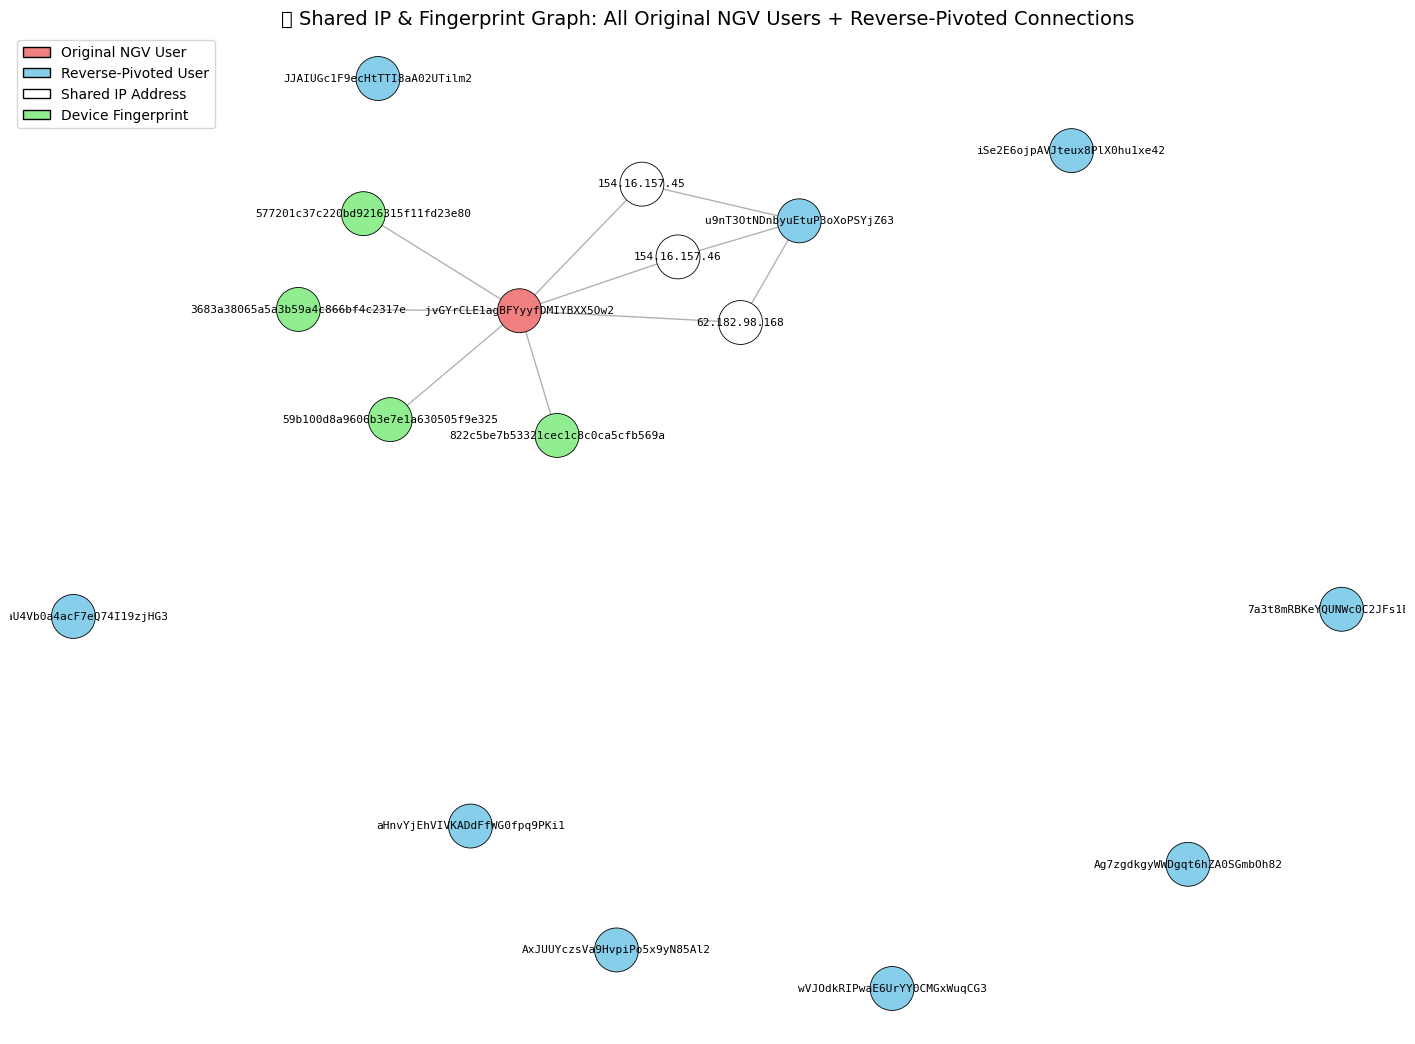

In [84]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Step 1: Build the graph
G = nx.Graph()

# Add all shared IP edges (reverse ↔ IP ↔ original)
for _, row in shared_ip_df.iterrows():
    ip = row["ip"]
    reverse_uid = row["user_uid_reverse"]
    original_uid = row["user_uid_original"]

    G.add_node(ip, label=ip, type="ip")

    G.add_node(reverse_uid, label=reverse_uid, type="reverse_user")
    G.add_edge(reverse_uid, ip)

    G.add_node(original_uid, label=original_uid, type="original_user")
    G.add_edge(original_uid, ip)

# Step 2: Force-add all original NGV users (even if no shared IPs)
for uid in stitched_df["user_uid"].unique():
    if not G.has_node(uid):
        G.add_node(uid, label=uid, type="original_user")

    user_fps = fingerprint_df[fingerprint_df["user_id"] == uid]["device_fingerprint"].unique()
    for fp in user_fps:
        G.add_node(fp, label=fp, type="fingerprint")
        G.add_edge(uid, fp)

# Step 3: Add fingerprints for reverse users (optional, if desired)
for uid in reverse_fp_ip_df["user_uid"].unique():
    if not G.has_node(uid):
        G.add_node(uid, label=uid, type="reverse_user")

    user_fps = fingerprint_df[fingerprint_df["user_id"] == uid]["device_fingerprint"].unique()
    for fp in user_fps:
        G.add_node(fp, label=fp, type="fingerprint")
        G.add_edge(uid, fp)

# Step 4: Assign node colors
color_map = []
for node, data in G.nodes(data=True):
    t = data.get("type")
    if t == "reverse_user":
        color_map.append("skyblue")
    elif t == "original_user":
        color_map.append("lightcoral")
    elif t == "fingerprint":
        color_map.append("lightgreen")
    else:  # IP
        color_map.append("white")

# Step 5: Draw the graph
plt.figure(figsize=(18, 13))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_color=color_map, edgecolors="black", node_size=1000, linewidths=0.6)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8, font_family="monospace")

plt.title("🕸️ Shared IP & Fingerprint Graph: All Original NGV Users + Reverse-Pivoted Connections", fontsize=14)
plt.axis("off")

# Step 6: Add Legend
legend_elements = [
    Patch(facecolor='lightcoral', edgecolor='black', label='Original NGV User'),
    Patch(facecolor='skyblue', edgecolor='black', label='Reverse-Pivoted User'),
    Patch(facecolor='white', edgecolor='black', label='Shared IP Address'),
    Patch(facecolor='lightgreen', edgecolor='black', label='Device Fingerprint'),
]
plt.legend(handles=legend_elements, loc='upper left', fontsize=10, frameon=True)

plt.show()


Final Investigation Narrative – NGV | Israel & Iran
This investigation centered on the user jvGYrCLE1agBFYyyfDMIYBXX5Ow2, associated with the email address blakejimmy111@gmail.com, who was previously flagged for suspicious NGV cloning behavior.

Over a 30-day window, we retrieved and analyzed all TTS generations by this user. Generations were stitched into cohesive narratives based on voice name and session proximity. Several narrative blocks exhibited abuse categories that overlap with previously red-teamed TTS misuse patterns, including:

Scripted behavioral mimicry

Multiple voice persona switches

Potential geo-political or impersonation intent

From these TTS logs, we extracted all associated IP addresses and enriched them with usage timestamps.

We then conducted device fingerprint reverse pivoting, identifying users who shared browser/device fingerprint identifiers with the original suspect. This yielded one highly suspicious reverse-pivoted user:

UID: u9nT3OtNDnbyuEtuP3oXoPSYjZ63

Email: (not found in available data)

Shared multiple IPs with the original actor, including:

154.16.157.45

154.16.157.46

62.182.98.168

These overlaps occurred on 2025-07-08 and 2025-07-15, coinciding with high activity days for the original user.

A graph visualization confirms dense connectivity between the original and reverse-pivoted users across fingerprint and IP pivots.

Conclusion:
The investigation reveals strong infrastructure linkage between blakejimmy111@gmail.com and a secondary account that likely serves as a continuation or circumvention mechanism. The behavior suggests evasive usage tactics, likely aimed at bypassing NGV enforcement mechanisms or distributing abuse across accounts.

Recommendations:

Flag u9nT3OtNDnbyuEtuP3oXoPSYjZ63 for suspension or deeper analysis.

Consider retroactive generation review.

Apply NGV cloning detection retroactively to both users’ TTS usage.



In [79]:
import pandas as pd
from google.colab import files

# Step 1: Upload file
print("📁 Please upload your Stripe CSV file:")
uploaded = files.upload()

# Step 2: Load into DataFrame
if uploaded:
    filename = list(uploaded.keys())[0]
    stripe_df = pd.read_csv(filename)

    print(f"✅ Stripe data loaded: {filename}")
    print(f"📊 Shape: {stripe_df.shape}")
    print("📄 Columns:", list(stripe_df.columns))
else:
    print("⚠️ No file uploaded.")


📁 Please upload your Stripe CSV file:


⚠️ No file uploaded.
